# Imports for datascience project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub


# Upload csv file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving wine-reviews.csv to wine-reviews.csv


# Add file to dataframe

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description','points','price','variety','winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset= ["description","points"]) # remove rows where not available data exists

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


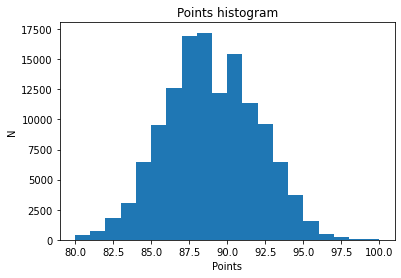

In [ ]:
plt.hist(df.points, bins=20) #shows the distribution of values
#plt.hist()
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

# Split to a high tier and low tier

In [ ]:
df["hi-tier"] = (df.points >= 90).astype(int) # come up with a new label where if points column of dataframe, which will return true if greater than or false if less than
df = df[["description", "hi-tier"]] # define dataframe as description and label

In [ ]:
df.tail()

,description,hi-tier
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1
129970,"Big, rich and off-dry, this is powered by inte...",1


# Split to test and validation dataframe

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))]) # split dataframe, sample from all of the them through random samples, call out breaks in the dataframe to split between test and valid
#samples data from the entire dataframe (sample(frac=1))
#.8 is the 80% that goes to the training set
#.9 is the 10% that goes to validation
# And the remaining 10% goes to the test set


In [ ]:
len(train), len(val), len(test)

(103976, 12997, 12998)

# Convert each training, validation, and test set Dataframe into a tf.data.dataset

In [ ]:
# This function shuffles, formats, and batches the given data
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): #Batch size increased due to large dataset
  df = dataframe.copy()
  labels = df.pop('hi-tier') # Set target variable to our label which has our boolean of high tier wine or not high tier (i.e. low)
  df = df["description"] # Set to description since this is the only part of the dataframe that matters
  ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Replace dict(df) with our df
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE) # With the Autotune finds good allocation for CPU budget
  return ds
  # Use this function from: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
  # Converts each set into a Dataset object that allows for batching and shuffling the data

In [ ]:
# Pass each set through the function above
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0][0]

<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'Muted at first, this wine opens up nicely with time. Sweet, ripe and easy on the finish, its core is full of black pepper and clove. The grapes are sourced from several distinctive vineyards in Mendocino County. Drink it with a steak.',
       b'A useful Bordeaux-style blend, dry and tannic, with blackberry, blueberry and chocolate flavors that finish sweet and spicy.',
       b'Aromas of ripe black plum, underbrush and exotic spice come together on this brawny red. The firm palate offers black cherry extract, blackberry jam, licorice and mocha alongside chewy tannins.',
       ...,
       b"A little scoury, but elegant, with rich flavors of yeast, toast, pears, limes, Meyer lemons and honey. It's made from Pinot Blanc.",
       b'This five grape Bordeaux-style blend has a sharp, spicy aroma, a strong suggestion of clove. The fruit is quite light and tastes of strawberries, but quickly is overtaken by the tannins and the barrel f

# Use embedding to transform text to ints for better computer understanding

Transform our text to a vector of numbers

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"# token-based text embedding
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable = True)

In [ ]:
hub_layer(list(train_data)[0][0]) # convert test to a vector with a length of 50 containing only numbers
# Map sentences in our description to length of 50 vector containing only numbers

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.03868935, -0.45176175, -0.03011275, ...,  0.04377879,
        -0.15175888, -0.09285533],
       [ 0.8468187 , -0.10553302,  0.07092613, ...,  0.09485496,
        -0.24412265,  0.20043027],
       [ 0.4252132 , -0.26208755, -0.13913034, ...,  0.02489118,
        -0.17200981, -0.28228176],
       ...,
       [ 0.5638097 , -0.1548802 ,  0.30793047, ..., -0.2174108 ,
        -0.19172277,  0.13032041],
       [ 0.28797325, -0.1686547 , -0.05652497, ..., -0.08352587,
         0.07835851, -0.12797405],
       [ 0.2906689 ,  0.15586483,  0.22084771, ..., -0.04993458,
        -0.19453487,  0.17783739]], dtype=float32)>

# Create model

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer) # Text to numerical 
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) # Added layers to correct bad nodes
model.add(tf.keras.layers.Dense(1,activation='sigmoid')) # Final output

# Compile model

In [ ]:
model.compile(optimizer="adam",
              loss = tf.keras.losses.BinaryCrossentropy(), # Used since performing binary classification
              metrics=['accuracy']
)

# Have model evaluate data

In [ ]:
model.evaluate(train_data)


102/102 [==============================] - 1s 11ms/step - loss: 0.7244 - accuracy: 0.3794


[0.7243705987930298, 0.3794337213039398]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 1s 74ms/step - loss: 0.6791 - accuracy: 0.6348


[0.6790690422058105, 0.6347618699073792]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data = valid_data)

Epoch 1/5
102/102 [==============================] - 56s 539ms/step - loss: 0.5966 - accuracy: 0.6540 - val_loss: 0.4867 - val_accuracy: 0.7897
Epoch 2/5
102/102 [==============================] - 57s 560ms/step - loss: 0.4700 - accuracy: 0.7741 - val_loss: 0.4097 - val_accuracy: 0.8172
Epoch 3/5
102/102 [==============================] - 57s 556ms/step - loss: 0.4021 - accuracy: 0.8282 - val_loss: 0.3846 - val_accuracy: 0.8262
Epoch 4/5
102/102 [==============================] - 57s 543ms/step - loss: 0.3665 - accuracy: 0.8475 - val_loss: 0.3790 - val_accuracy: 0.8313
Epoch 5/5
102/102 [==============================] - 55s 539ms/step - loss: 0.3417 - accuracy: 0.8587 - val_loss: 0.3771 - val_accuracy: 0.8348


# Observation from training

As a result of training, it can be seen that there is over-fitting occuring where the model can predict the data very well but generalizes poorly. Below code attempts to correct it.

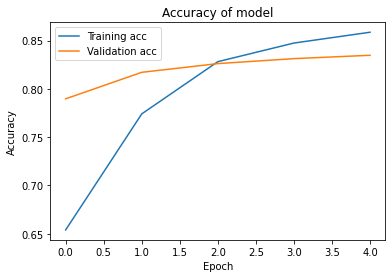

In [ ]:
plt.plot(history.history['accuracy'], label = "Training acc")
plt.plot(history.history['val_accuracy'], label = "Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

Now observing the loss

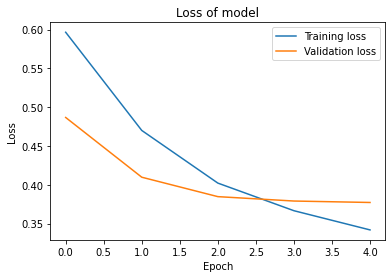

In [ ]:
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Results


Our model is not able to generalize since it's trained so much in data that we are feeding it.

## To fix this need to include dropout

This involves selecting a few nodes that are not working every once in a while.
This involves updating our model.
These dropout layers force the model to figure out how to work around nodes that aren't working.

# Evaluate against our test data to get our final results

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 105ms/step - loss: 0.3688 - accuracy: 0.8346


[0.36877956986427307, 0.834589958190918]